# Load Data

In [23]:
def get_real_data():
    df = pd.read_csv("Full_CrossCheck_Hourly_Data.csv")
    df = df.set_index("study_id").sort_index()
    df = df.drop(["hour", "day", "filled_pct", "weighted_distance_sum"], axis=1)

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i : i + seq_len])
    return data

In [24]:
real_data = get_real_data()

In [25]:
n = len(real_data)

In [26]:
np.asarray(real_data).shape

(483768, 24, 27)

In [28]:
synthetic_data = np.load("logs/data/generated_data.npy")
synthetic_data.shape

(483712, 24, 27)

In [30]:
real_data = real_data[: synthetic_data.shape[0]]

# Prepare Sample

In [31]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [32]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [33]:
# Reshape real and synthetic samples
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)
real_sample_2d = real_sample.reshape(-1, seq_len)

In [34]:
real_sample_2d.shape, synthetic_sample_2d.shape

((6750, 24), (6750, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = pd.DataFrame(pca.transform(real_sample_2d)).assign(Data="Real")
pca_synthetic = pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(
    Data="Synthetic"
)
pca_result = pd.concat([pca_real, pca_synthetic]).rename(
    columns={0: "1st Component", 1: "2nd Component"}
)

## Run t-SNE

In [36]:
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13500 samples in 0.001s...
[t-SNE] Computed neighbors for 13500 samples in 0.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13500
[t-SNE] Computed conditional probabilities for sample 2000 / 13500
[t-SNE] Computed conditional probabilities for sample 3000 / 13500
[t-SNE] Computed conditional probabilities for sample 4000 / 13500
[t-SNE] Computed conditional probabilities for sample 5000 / 13500
[t-SNE] Computed conditional probabilities for sample 6000 / 13500
[t-SNE] Computed conditional probabilities for sample 7000 / 13500
[t-SNE] Computed conditional probabilities for sample 8000 / 13500
[t-SNE] Computed conditional probabilities for sample 9000 / 13500
[t-SNE] Computed conditional probabilities for sample 10000 / 13500
[t-SNE] Computed conditional probabilities for sample 11000 / 13500
[t-SNE] Computed conditional probabilities for sample 12000 / 13500
[t-SNE] Computed conditional probabilities for sa

In [37]:
tsne_result = pd.DataFrame(tsne_result, columns=["X", "Y"]).assign(Data="Real")
tsne_result.loc[sample_size * seq_len :, "Data"] = "Synthetic"

## Plot Result

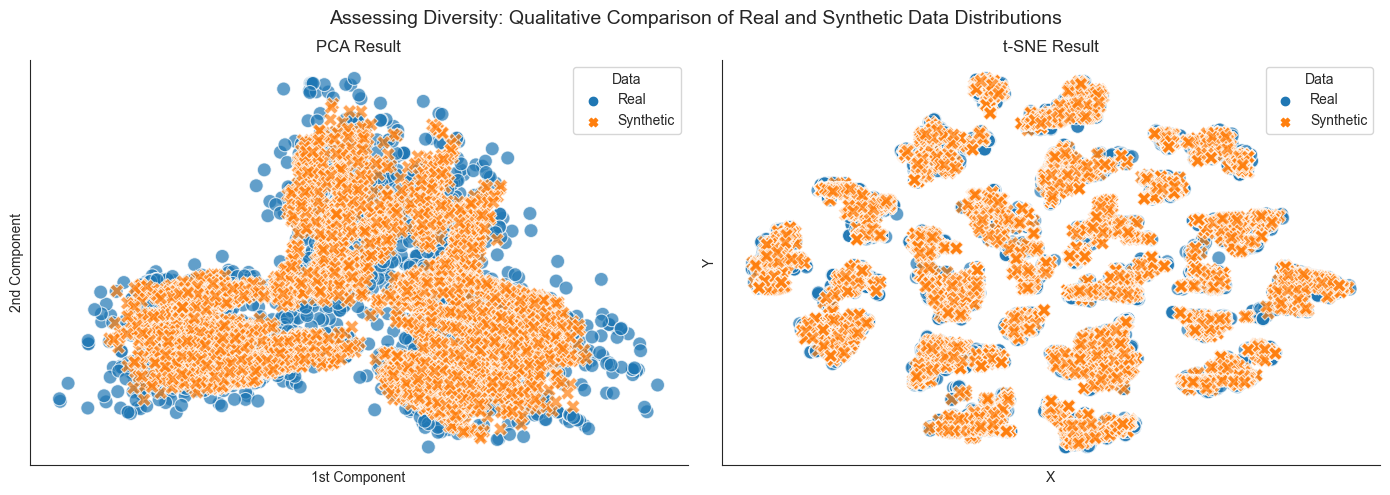

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(
    x="1st Component",
    y="2nd Component",
    data=pca_result,
    hue="Data",
    style="Data",
    ax=axes[0],
    s=100,  # Increase size of the points
    alpha=0.7,  # Increase transparency of the points
)
sns.despine()
axes[0].set_title("PCA Result")


sns.scatterplot(
    x="X",
    y="Y",
    data=tsne_result,
    hue="Data",
    style="Data",
    ax=axes[1],
    s=100,
    alpha=0.7,
)
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title("t-SNE Result")
fig.suptitle(
    "Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions",
    fontsize=14,
)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

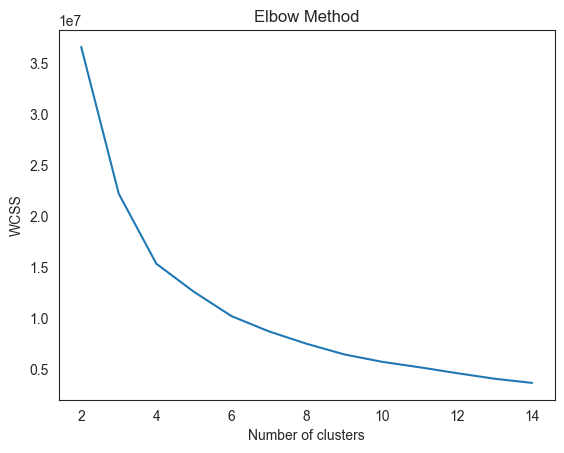

The optimal number of clusters is: 3


In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Extract the 2D t-SNE results
X = tsne_result[["X", "Y"]]

# Use the elbow method to find a good number of clusters
wcss = []
silhouette = []
K_range = range(2, 15)  # Adjust this range based on your specific case

for i in K_range:
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0
    )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

# Plot the elbow graph
plt.figure()
plt.plot(K_range, wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# Find the optimal number of clusters (where the elbow occurs)
optimal_K = K_range[wcss.index(min(wcss[1:], key=lambda x: abs(x - wcss[0])))]
print(f"The optimal number of clusters is: {optimal_K}")

In [40]:
# plotly tsne and pca plots
import plotly.express as px

pca_result["Data"] = pca_result["Data"].astype("category")
pca_result["Data"] = pca_result["Data"].cat.reorder_categories(["Real", "Synthetic"])

tsne_result["Data"] = tsne_result["Data"].astype("category")
tsne_result["Data"] = tsne_result["Data"].cat.reorder_categories(["Real", "Synthetic"])

In [41]:
fig = px.scatter(
    pca_result,
    x="1st Component",
    y="2nd Component",
    color="Data",
    symbol="Data",
    opacity=0.7,
    title="PCA Result",
)
fig.update_layout(height=800)  # Increase the height of the plot
fig.show()

In [42]:
fig = px.scatter(
    tsne_result,
    x="X",
    y="Y",
    color="Data",
    symbol="Data",
    opacity=0.7,
    title="t-SNE Result",
)
fig.update_layout(height=800)
fig.show()

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [43]:
real_data = get_real_data()
real_data = np.array(real_data)[: len(synthetic_data)]
real_data.shape

(483712, 24, 27)

In [44]:
synthetic_data.shape

(483712, 24, 27)

In [45]:
n_series = real_data.shape[0]

In [46]:
idx = np.arange(n_series)

In [47]:
n_train = int(0.8 * n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [106]:
train_data = np.vstack((real_data[train_idx], synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], synthetic_data[test_idx]))

In [107]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train), np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test), np.zeros(n_test)))

In [108]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((773938, 24, 27), (773938,), (193486, 24, 27), (193486,))

## Create Classifier

In [109]:
ts_classifier = Sequential(
    [
        GRU(27, input_shape=(24, 27), name="GRU"),
        Dense(1, activation="sigmoid", name="OUT"),
    ],
    name="Time_Series_Classifier",
)

In [113]:
ts_classifier.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[AUC(name="AUC"), "accuracy"]
)

In [114]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 27)                4536      
                                                                 
 OUT (Dense)                 (None, 1)                 28        
                                                                 
Total params: 4,564
Trainable params: 4,564
Non-trainable params: 0
_________________________________________________________________


In [115]:
result = ts_classifier.fit(
    x=train_data,
    y=train_labels,
    validation_data=(test_data, test_labels),
    epochs=250,
    batch_size=128,
    verbose=1,
)

Epoch 1/250
6047/6047 [==============================] - 56s 9ms/step - loss: 0.1829 - AUC: 0.9778 - accuracy: 0.9208 - val_loss: 0.1660 - val_AUC: 0.9830 - val_accuracy: 0.9404
Epoch 2/250
6047/6047 [==============================] - 52s 9ms/step - loss: 0.0280 - AUC: 0.9987 - accuracy: 0.9918 - val_loss: 0.2052 - val_AUC: 0.9803 - val_accuracy: 0.9469
Epoch 3/250
6047/6047 [==============================] - 53s 9ms/step - loss: 0.0140 - AUC: 0.9994 - accuracy: 0.9960 - val_loss: 0.2445 - val_AUC: 0.9776 - val_accuracy: 0.9439
Epoch 4/250
6047/6047 [==============================] - 50s 8ms/step - loss: 0.0084 - AUC: 0.9997 - accuracy: 0.9977 - val_loss: 0.2381 - val_AUC: 0.9762 - val_accuracy: 0.9538
Epoch 5/250
6047/6047 [==============================] - 53s 9ms/step - loss: 0.0058 - AUC: 0.9998 - accuracy: 0.9984 - val_loss: 0.2050 - val_AUC: 0.9829 - val_accuracy: 0.9560
Epoch 6/250
6047/6047 [==============================] - 55s 9ms/step - loss: 0.0042 - AUC: 0.9998 - accuracy:

In [116]:
ts_classifier.evaluate(x=test_data, y=test_labels)

6047/6047 [==============================] - 27s 4ms/step - loss: 0.0503 - AUC: 0.9955 - accuracy: 0.9908


[0.050285447388887405, 0.9955187439918518, 0.9908365607261658]

In [117]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [118]:
from matplotlib.ticker import FuncFormatter

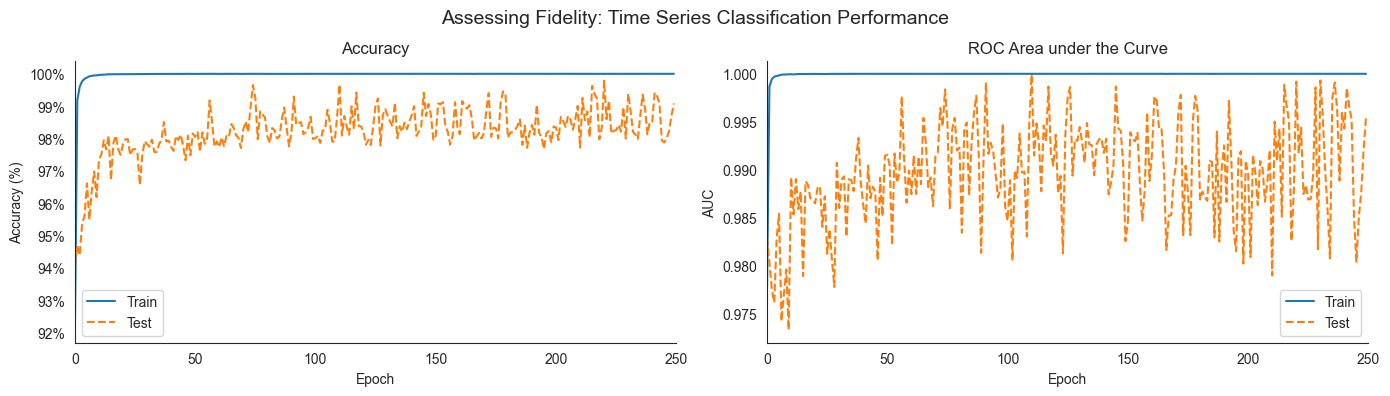

In [119]:
sns.set_style("white")
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
history[["AUC", "val_AUC"]].rename(columns={"AUC": "Train", "val_AUC": "Test"}).plot(
    ax=axes[1], title="ROC Area under the Curve", style=["-", "--"], xlim=(0, 250)
)
history[["accuracy", "val_accuracy"]].rename(
    columns={"accuracy": "Train", "val_accuracy": "Test"}
).plot(ax=axes[0], title="Accuracy", style=["-", "--"], xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel("Epoch")

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
axes[0].set_ylabel("Accuracy (%)")
axes[1].set_ylabel("AUC")
sns.despine()
fig.suptitle("Assessing Fidelity: Time Series Classification Performance", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

# Train on Synthetic, test on real: Assessing usefulness

In [62]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    MeanSquaredError,
    MeanAbsoluteError,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
real_data = get_real_data()
real_data = np.array(real_data)[: len(synthetic_data)]

In [64]:
real_data.shape, synthetic_data.shape

((483712, 24, 27), (483712, 24, 27))

In [51]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [52]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((386969, 23, 27), (386969, 27), (96743, 23, 27), (96743, 27))

In [53]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [54]:
synthetic_train.shape, synthetic_label.shape

((483712, 23, 27), (483712, 27))

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam


# Define the model
def get_model():
    model = Sequential([GRU(12, input_shape=(23, 27)), Dense(27)])

    # Use string for loss function
    model.compile(optimizer=Adam(), loss="mean_absolute_error")
    return model

In [58]:
# Initialize and train the model
ts_regression = get_model()
synthetic_result = ts_regression.fit(
    x=synthetic_train,
    y=synthetic_label,
    validation_data=(real_test_data, real_test_label),
    epochs=100,
    batch_size=128,
    verbose=1,
)

Epoch 1/100
3779/3779 [==============================] - 29s 6ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 2/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0136 - val_loss: 0.0179
Epoch 3/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0132 - val_loss: 0.0181
Epoch 4/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0130 - val_loss: 0.0184
Epoch 5/100
3779/3779 [==============================] - 21s 6ms/step - loss: 0.0128 - val_loss: 0.0184
Epoch 6/100
3779/3779 [==============================] - 20s 5ms/step - loss: 0.0127 - val_loss: 0.0184
Epoch 7/100
3779/3779 [==============================] - 20s 5ms/step - loss: 0.0125 - val_loss: 0.0185
Epoch 8/100
3779/3779 [==============================] - 19s 5ms/step - loss: 0.0124 - val_loss: 0.0186
Epoch 9/100
3779/3779 [==============================] - 20s 5ms/step - loss: 0.0124 - val_loss: 0.0188
Epoch 10/100
3779/3779 [==============================] - 19s 5m

In [59]:
ts_regression = get_model()
real_result = ts_regression.fit(
    x=real_train_data,
    y=real_train_label,
    validation_data=(real_test_data, real_test_label),
    epochs=100,
    batch_size=128,
    verbose=1,
)

Epoch 1/100
3024/3024 [==============================] - 27s 8ms/step - loss: 0.0210 - val_loss: 0.0173
Epoch 2/100
3024/3024 [==============================] - 24s 8ms/step - loss: 0.0132 - val_loss: 0.0162
Epoch 3/100
3024/3024 [==============================] - 24s 8ms/step - loss: 0.0128 - val_loss: 0.0160
Epoch 4/100
3024/3024 [==============================] - 24s 8ms/step - loss: 0.0127 - val_loss: 0.0159
Epoch 5/100
3024/3024 [==============================] - 23s 8ms/step - loss: 0.0121 - val_loss: 0.0142
Epoch 6/100
3024/3024 [==============================] - 22s 7ms/step - loss: 0.0116 - val_loss: 0.0142
Epoch 7/100
3024/3024 [==============================] - 22s 7ms/step - loss: 0.0116 - val_loss: 0.0141
Epoch 8/100
3024/3024 [==============================] - 22s 7ms/step - loss: 0.0116 - val_loss: 0.0141
Epoch 9/100
3024/3024 [==============================] - 23s 7ms/step - loss: 0.0116 - val_loss: 0.0141
Epoch 10/100
3024/3024 [==============================] - 22s 7m

In [60]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(
    columns={"loss": "Train", "val_loss": "Test"}
)
real_result = pd.DataFrame(real_result.history).rename(
    columns={"loss": "Train", "val_loss": "Test"}
)

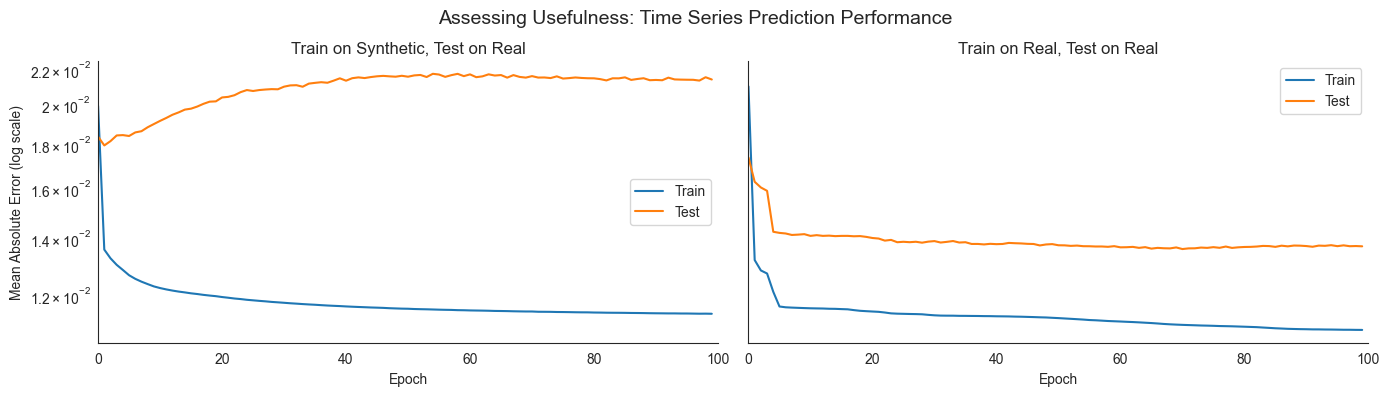

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(
    ax=axes[0], title="Train on Synthetic, Test on Real", logy=True, xlim=(0, 100)
)
real_result.plot(
    ax=axes[1], title="Train on Real, Test on Real", logy=True, xlim=(0, 100)
)
for i in [0, 1]:
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Mean Absolute Error (log scale)")

sns.despine()
fig.suptitle("Assessing Usefulness: Time Series Prediction Performance", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

It means that the model trained on synthetic data is overfitting the training data. Overfitting is a problem that occurs when a model learns the training data too well and is unable to generalize to new data. In this case, the model is learning the patterns in the synthetic data, but these patterns are not present in the real data. This is why the model has a higher MAE when it is tested on the real data.

There are a few things you can do to prevent overfitting:

* Use a regularization technique, such as L1 or L2 regularization. Regularization helps to penalize the model for learning too complex patterns in the training data.
* Use a smaller model. A smaller model has fewer parameters, which makes it less likely to overfit the training data.
* Use a more diverse training dataset. A more diverse training dataset will help the model to learn more general patterns, which will make it less likely to overfit.

If you are still getting overfitting, you can try a combination of these techniques.

In your case, the model trained on synthetic data has the same MAE as the model trained on real data because the synthetic data is very similar to the real data. However, when the model is tested on the real data, it has a higher MAE because the real data is not as perfectly structured as the synthetic data.

One way to improve the performance of the model on the real data is to use a more diverse training dataset. This will help the model to learn more general patterns, which will make it less likely to overfit to the synthetic data. You can also try using a regularization technique, such as L1 or L2 regularization. Regularization helps to penalize the model for learning too complex patterns in the training data, which can help to prevent overfitting.